# Install

In [1]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [2]:
! pip install xgboost

In [3]:
! pip install gensim

# Imports

In [4]:
import os
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from datasets import load_dataset

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [5]:
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Mount google drive

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


# Config

In [9]:
# Locations
DRIVE_PATH = '/content/drive/My Drive/'
DATA_DIR = 'Study/Projects/Problem statements/movie_review_classification/data/'
RES_DIR = 'Study/Projects/Problem statements/movie_review_classification/results/'

# Debug
debug = True

# Dataset
DATASET_NAME = "imdb"

# Limit the data size (for testing purpose)
LIMIT_DATA = False
LIMIT_DATA_SIZE = 100

# Pre-processing flags
PR_REMOVE_PUNCTUATIONS = True
PR_REMOVE_SPECIAL_CHAR = True
PR_REMOVE_HTML_TAGS = True
PR_REMOVE_STOPWORDS = True
PR_REMOVE_URL = True
PR_REMOVE_EXTRA_SPACE = True
PR_LEMMATIZATION = True

# Unknown token
UNK_TOKEN = 'UNK'
UNK_TOKEN_IDX = 1

# Padding
PAD = 'PAD'
PAD_IDX = 0

# Number of features for BOW, TF-IDF based models
NUM_FEATURES = 5000

# Random state for classifiers
RANDOM_STATE = 42

# Target labels
POS_LABEL = 1
NEG_LABEL = 0

# Word2Vec
EMB_SIZE = 100

# LSTM, CNN Model
NUM_TIMESTEPS = 150 # Number of timesteps (after padding/truncating)
EMB_SIZE_2 = 300 # Embedding dimension
BATCH_SIZE = 512 # Batch size
NUM_EPOCHS = 25 # Number of epochs
LEARNING_RATE = 0.001 # Learning rate

# Utils

### Baseline classification models

In [10]:
def base_classification_model(train_features, train_labels, test_features, test_labels):

    # Check: Logistic regression code

    # Logistic Regression classifier
    print(f'LOGISTIC REGRESSION CLASSIFIER')
    lr_classifier = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    lr_classifier.fit(train_features, train_labels)
    y_pred = lr_classifier.predict(test_features)
    model_evaluate(list(test_labels), y_pred, True)
    print('===================================================')

    # Random forest classifer
    print(f'RANDOM FOREST CLASSIFIER:')
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
    rf_classifier.fit(train_features, train_labels)
    y_pred = rf_classifier.predict(test_features)
    model_evaluate(list(test_labels), y_pred, True)
    print('===================================================')

    # XGBoost classifer
    print(f'XGBoost CLASSIFIER')
    xgb_classifier = XGBClassifier(random_state=RANDOM_STATE)
    xgb_classifier.fit(train_features, train_labels)
    y_pred_1 = xgb_classifier.predict(test_features)
    model_evaluate(list(test_labels), y_pred_1, True)
    print('===================================================')

    # LightGBM classifer
    print(f'LightGBM CLASSIFIER')
    lgbm_classifier = LGBMClassifier(random_state=RANDOM_STATE)
    lgbm_classifier.fit(train_features, train_labels)
    # lgbm_classifier.fit(pd.DataFrame(train_features.values), train_labels)
    y_pred_2 = lgbm_classifier.predict(test_features)
    # y_pred_2 = lgbm_classifier.predict(pd.DataFrame(test_features.values))
    model_evaluate(list(test_labels), y_pred_2, True)
    print('===================================================')

### Classification metrics

In [11]:
def model_evaluate(true_val, pred_val, print_res):

    '''
    Calculate classification metrics (Accuracy, Precision, Recall, F1-Score)
    '''

    true_val = list(true_val)
    pred_val = list(pred_val)

    tp = 0 # Number of true positives
    tn = 0 # Number of true negatives
    fp = 0 # Number of false positives
    fn = 0 # Number of false negatives

    for i in range(len(true_val)): # For each sample

        if true_val[i] == pred_val[i]:
            if true_val[i] == POS_LABEL:
                tp += 1
            elif true_val[i] == NEG_LABEL:
                tn += 1

        if (true_val[i] == NEG_LABEL) and (pred_val[i] == POS_LABEL):
            fp += 1

        if (true_val[i] == POS_LABEL) and (pred_val[i] == NEG_LABEL):
            fn += 1

    accuracy = round(((tp + tn) / (tp + tn + fp + fn)) * 100, 2) # Overall accuracy

    precision_pos = round(((tp) / (tp + fp)) * 100, 2) # Precision of positive class
    recall_pos = round(((tp) / (tp + fn)) * 100, 2) # Recall of positive class (Sensitivity)
    f1_pos = round(((2 * precision_pos * recall_pos) / (precision_pos + recall_pos)), 2) # F1 Score of positive class

    precision_neg = round(((tn) / (tn + fn)) * 100, 2)
    recall_neg = round(((tn) / (tn + fp)) * 100, 2) # Specificity
    f1_neg = round(((2 * precision_neg * recall_neg) / (precision_neg + recall_neg)), 2)

    # Print metrics
    if print_res:
        print(f'Accuracy: {accuracy}')
        print(f'TP: {tp}')
        print(f'TN: {tn}')
        print(f'FP: {fp}')
        print(f'FN: {fn}')
        print(f'precision_pos: {precision_pos}')
        print(f'precision_neg: {precision_neg}')
        print(f'recall_pos: {recall_pos}')
        print(f'recall_neg: {recall_neg}')
        print(f'f1_pos: {f1_pos}')
        print(f'f1_neg: {f1_neg}')

    else:
        return [accuracy, tp, tn, fp, fn, precision_pos, precision_neg, recall_pos, recall_neg, f1_pos, f1_neg]

### Write pandas df as csv in drive

In [12]:
def write_to_drive(df, location, filename):
    print(f'Saving {filename} to {DRIVE_PATH + location}')
    df.to_csv(DRIVE_PATH + location + filename, index=False)

### Write dictionary

In [13]:
def write_dict(dict_data, location, filename):
    with open(DRIVE_PATH + location + filename + '.json', 'w') as json_file:
        json.dump(dict_data, json_file)

### Read dictionary

In [14]:
def read_dict(location, filename):
    with open(DRIVE_PATH + location + filename + '.json', 'r') as json_file:
        return(json.load(json_file))

# Read data

In [15]:
train_df = pd.read_csv(DRIVE_PATH + DATA_DIR + 'train_df_1.csv')

In [16]:
test_df = pd.read_csv(DRIVE_PATH + DATA_DIR + 'test_df_1.csv')

In [17]:
train_df.shape, test_df.shape

((25000, 4), (25000, 4))

In [18]:
train_df.head()

,text,label,text_preprocessed,text_preprocessed_1
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,rented curiousyellow video store controversy s...,rent curiousyellow video store controversy sur...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,curious yellow risible pretentious steaming pi...,curious yellow risible pretentious steam pile ...
2,If only to avoid making this type of film in t...,0,avoid making type film future film interesting...,avoid make type film future film interest expe...
3,This film was probably inspired by Godard's Ma...,0,film probably inspired godards masculin f mini...,film probably inspire godards masculin f minin...
4,"Oh, brother...after hearing about this ridicul...",0,oh brotherafter hearing ridiculous film umptee...,oh brotherafter hear ridiculous film umpteen y...


In [19]:
test_df.head()

,text,label,text_preprocessed,text_preprocessed_1
0,I love sci-fi and am willing to put up with a ...,0,love scifi willing put lot scifi moviestv usua...,love scifi will put lot scifi moviestv usually...
1,"Worth the entertainment value of a rental, esp...",0,worth entertainment value rental especially li...,worth entertainment value rental especially li...
2,its a totally average film with a few semi-alr...,0,totally average film semialright action sequen...,totally average film semialright action sequen...
3,STAR RATING: ***** Saturday Night **** Friday ...,0,star rating saturday night friday night friday...,star rat saturday night friday night friday mo...
4,"First off let me say, If you haven't enjoyed a...",0,first let say havent enjoyed van damme movie s...,first let say havent enjoy van damme movie sin...


# Data Pre-processing

### Tokenization

In [20]:
def tokenize_data(x):
    return (x.split(' '))

In [21]:
train_df['tokenized_review'] = train_df['text_preprocessed_1'].apply(tokenize_data)
test_df['tokenized_review'] = test_df['text_preprocessed_1'].apply(tokenize_data)

In [22]:
train_df.head()

,text,label,text_preprocessed,text_preprocessed_1,tokenized_review
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,rented curiousyellow video store controversy s...,rent curiousyellow video store controversy sur...,"[rent, curiousyellow, video, store, controvers..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,curious yellow risible pretentious steaming pi...,curious yellow risible pretentious steam pile ...,"[curious, yellow, risible, pretentious, steam,..."
2,If only to avoid making this type of film in t...,0,avoid making type film future film interesting...,avoid make type film future film interest expe...,"[avoid, make, type, film, future, film, intere..."
3,This film was probably inspired by Godard's Ma...,0,film probably inspired godards masculin f mini...,film probably inspire godards masculin f minin...,"[film, probably, inspire, godards, masculin, f..."
4,"Oh, brother...after hearing about this ridicul...",0,oh brotherafter hearing ridiculous film umptee...,oh brotherafter hear ridiculous film umpteen y...,"[oh, brotherafter, hear, ridiculous, film, ump..."


In [23]:
test_df.head()

,text,label,text_preprocessed,text_preprocessed_1,tokenized_review
0,I love sci-fi and am willing to put up with a ...,0,love scifi willing put lot scifi moviestv usua...,love scifi will put lot scifi moviestv usually...,"[love, scifi, will, put, lot, scifi, moviestv,..."
1,"Worth the entertainment value of a rental, esp...",0,worth entertainment value rental especially li...,worth entertainment value rental especially li...,"[worth, entertainment, value, rental, especial..."
2,its a totally average film with a few semi-alr...,0,totally average film semialright action sequen...,totally average film semialright action sequen...,"[totally, average, film, semialright, action, ..."
3,STAR RATING: ***** Saturday Night **** Friday ...,0,star rating saturday night friday night friday...,star rat saturday night friday night friday mo...,"[star, rat, saturday, night, friday, night, fr..."
4,"First off let me say, If you haven't enjoyed a...",0,first let say havent enjoyed van damme movie s...,first let say havent enjoy van damme movie sin...,"[first, let, say, havent, enjoy, van, damme, m..."


### Numerically encode to index

##### Making index dictionary

In [24]:
word2idx2 = {}
idx2word2 = {}

# Padding index: 0
word2idx2[PAD] = PAD_IDX
idx2word2[PAD_IDX] = PAD

# Unknown token index: 1
word2idx2[UNK_TOKEN] = UNK_TOKEN_IDX
idx2word2[UNK_TOKEN_IDX] = UNK_TOKEN

word2idx2, idx2word2, len(word2idx2), len(idx2word2)

({'PAD': 0, 'UNK': 1}, {0: 'PAD', 1: 'UNK'}, 2, 2)

In [25]:
sorted_vocab = read_dict(DATA_DIR, 'sorted_vocab') # Vocab of all the words soreted (descending) by count

In [26]:
feature_list = list(sorted_vocab.keys())[:NUM_FEATURES+10]
len(feature_list), feature_list[0:10]
#  ['br', 'film', 'movie', 'one', 'make', 'like', 'see', 'get', 'time', 'good'])

(5010,
 ['br', 'film', 'movie', 'one', 'make', 'like', 'see', 'get', 'time', 'good'])

In [27]:
# Editing feature list (TODO: removing some noisy features which should have been handled after pre-processing)

# Removing 'br
feature_list.remove('br')
print(len(feature_list), feature_list[0:10])

# Removing ''
feature_list.remove('')
print(len(feature_list), feature_list[0:10])

feature_list = feature_list[:NUM_FEATURES]
print(len(feature_list), feature_list[0:10])

5009 ['film', 'movie', 'one', 'make', 'like', 'see', 'get', 'time', 'good', 'character']
5008 ['film', 'movie', 'one', 'make', 'like', 'see', 'get', 'time', 'good', 'character']
5000 ['film', 'movie', 'one', 'make', 'like', 'see', 'get', 'time', 'good', 'character']


In [28]:
for feature in feature_list:
    cur_length = len(word2idx2)
    word2idx2[feature] = cur_length
    idx2word2[cur_length] = feature

In [29]:
len(word2idx2), len(idx2word2)

(5002, 5002)

In [30]:
idx2word2[0], idx2word2[1], idx2word2[2], idx2word2[3]

('PAD', 'UNK', 'film', 'movie')

##### Encode

In [31]:
def convert_word_to_idx(x):
    return [word2idx2.get(word, UNK_TOKEN_IDX) for word in x]

In [32]:
train_df['tokenized_enc_review'] = train_df['tokenized_review'].apply(convert_word_to_idx)

In [33]:
test_df['tokenized_enc_review'] = test_df['tokenized_review'].apply(convert_word_to_idx)

In [34]:
train_df.head()

,text,label,text_preprocessed,text_preprocessed_1,tokenized_review,tokenized_enc_review
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,rented curiousyellow video store controversy s...,rent curiousyellow video store controversy sur...,"[rent, curiousyellow, video, store, controvers...","[425, 1, 322, 900, 1, 1211, 30, 265, 1, 27, 21..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,curious yellow risible pretentious steaming pi...,curious yellow risible pretentious steam pile ...,"[curious, yellow, risible, pretentious, steam,...","[1695, 3583, 1, 1656, 3710, 1802, 67, 392, 442..."
2,If only to avoid making this type of film in t...,0,avoid making type film future film interesting...,avoid make type film future film interest expe...,"[avoid, make, type, film, future, film, intere...","[533, 5, 405, 2, 612, 2, 65, 1606, 82, 1, 1937..."
3,This film was probably inspired by Godard's Ma...,0,film probably inspired godards masculin f mini...,film probably inspire godards masculin f minin...,"[film, probably, inspire, godards, masculin, f...","[2, 154, 923, 1, 1, 1938, 1, 2802, 7, 2, 1, 1,..."
4,"Oh, brother...after hearing about this ridicul...",0,oh brotherafter hearing ridiculous film umptee...,oh brotherafter hear ridiculous film umpteen y...,"[oh, brotherafter, hear, ridiculous, film, ump...","[375, 1, 211, 549, 2, 1, 69, 16, 87, 1, 742, 1..."


In [35]:
test_df.head()

,text,label,text_preprocessed,text_preprocessed_1,tokenized_review,tokenized_enc_review
0,I love sci-fi and am willing to put up with a ...,0,love scifi willing put lot scifi moviestv usua...,love scifi will put lot scifi moviestv usually...,"[love, scifi, will, put, lot, scifi, moviestv,...","[36, 852, 1290, 132, 66, 852, 1, 515, 1, 1, 33..."
1,"Worth the entertainment value of a rental, esp...",0,worth entertainment value rental especially li...,worth entertainment value rental especially li...,"[worth, entertainment, value, rental, especial...","[194, 635, 522, 2126, 182, 6, 110, 39, 4, 262,..."
2,its a totally average film with a few semi-alr...,0,totally average film semialright action sequen...,totally average film semialright action sequen...,"[totally, average, film, semialright, action, ...","[394, 755, 2, 1, 110, 319, 5, 46, 42, 49, 56, ..."
3,STAR RATING: ***** Saturday Night **** Friday ...,0,star rating saturday night friday night friday...,star rat saturday night friday night friday mo...,"[star, rat, saturday, night, friday, night, fr...","[81, 292, 2009, 229, 2171, 229, 2171, 1697, 23..."
4,"First off let me say, If you haven't enjoyed a...",0,first let say havent enjoyed van damme movie s...,first let say havent enjoy van damme movie sin...,"[first, let, say, havent, enjoy, van, damme, m...","[30, 159, 23, 639, 117, 1005, 4800, 3, 151, 1,..."


### Length EDA

In [36]:
def calc_num_words(x):
    return len(x.split(' '))

In [37]:
train_df['text_preprocessed_1_num_words'] = train_df['text_preprocessed_1'].apply(calc_num_words)

In [38]:
test_df['text_preprocessed_1_num_words'] = test_df['text_preprocessed_1'].apply(calc_num_words)

In [39]:
min(list(train_df['text_preprocessed_1_num_words'])), max(list(train_df['text_preprocessed_1_num_words']))

(4, 1450)

In [40]:
np.mean(list(train_df['text_preprocessed_1_num_words']))

124.26644

In [41]:
min(list(test_df['text_preprocessed_1_num_words'])), max(list(test_df['text_preprocessed_1_num_words']))

(3, 1191)

In [42]:
np.mean(list(test_df['text_preprocessed_1_num_words']))

121.44148

### Padding/Truncation

In [43]:
def pad_truncate(x, max_len, pre_post_pad='POST', pre_post_trunc='POST'):

    # If length greater than the max length
    if len(x) > max_len:
        # Post truncation
        if pre_post_trunc == 'POST':
            return x[:max_len]
        # Pre truncation
        if pre_post_trunc == 'PRE':
            return x[len(x) - max_len:]

    # If length smaller than the max length
    if len(x) < max_len:
        # Post padding
        if pre_post_pad == 'POST':
            return x + [PAD_IDX] * (max_len - len(x))
        # Pre padding
        if pre_post_pad == 'PRE':
            return [PAD_IDX] * (max_len - len(x)) + x

    # Same length
    return x

In [44]:
train_df['tokenized_enc_pad_review'] = train_df['tokenized_enc_review'].apply(lambda x: pad_truncate(x, max_len=NUM_TIMESTEPS))

In [45]:
train_df.head()

,text,label,text_preprocessed,text_preprocessed_1,tokenized_review,tokenized_enc_review,text_preprocessed_1_num_words,tokenized_enc_pad_review
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,rented curiousyellow video store controversy s...,rent curiousyellow video store controversy sur...,"[rent, curiousyellow, video, store, controvers...","[425, 1, 322, 900, 1, 1211, 30, 265, 1, 27, 21...",152,"[425, 1, 322, 900, 1, 1211, 30, 265, 1, 27, 21..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,curious yellow risible pretentious steaming pi...,curious yellow risible pretentious steam pile ...,"[curious, yellow, risible, pretentious, steam,...","[1695, 3583, 1, 1656, 3710, 1802, 67, 392, 442...",120,"[1695, 3583, 1, 1656, 3710, 1802, 67, 392, 442..."
2,If only to avoid making this type of film in t...,0,avoid making type film future film interesting...,avoid make type film future film interest expe...,"[avoid, make, type, film, future, film, intere...","[533, 5, 405, 2, 612, 2, 65, 1606, 82, 1, 1937...",53,"[533, 5, 405, 2, 612, 2, 65, 1606, 82, 1, 1937..."
3,This film was probably inspired by Godard's Ma...,0,film probably inspired godards masculin f mini...,film probably inspire godards masculin f minin...,"[film, probably, inspire, godards, masculin, f...","[2, 154, 923, 1, 1, 1938, 1, 2802, 7, 2, 1, 1,...",62,"[2, 154, 923, 1, 1, 1938, 1, 2802, 7, 2, 1, 1,..."
4,"Oh, brother...after hearing about this ridicul...",0,oh brotherafter hearing ridiculous film umptee...,oh brotherafter hear ridiculous film umpteen y...,"[oh, brotherafter, hear, ridiculous, film, ump...","[375, 1, 211, 549, 2, 1, 69, 16, 87, 1, 742, 1...",173,"[375, 1, 211, 549, 2, 1, 69, 16, 87, 1, 742, 1..."


In [46]:
len(train_df['tokenized_enc_pad_review'][2])

150

In [47]:
test_df['tokenized_enc_pad_review'] = test_df['tokenized_enc_review'].apply(lambda x: pad_truncate(x, max_len=NUM_TIMESTEPS))

In [48]:
test_df.head()

,text,label,text_preprocessed,text_preprocessed_1,tokenized_review,tokenized_enc_review,text_preprocessed_1_num_words,tokenized_enc_pad_review
0,I love sci-fi and am willing to put up with a ...,0,love scifi willing put lot scifi moviestv usua...,love scifi will put lot scifi moviestv usually...,"[love, scifi, will, put, lot, scifi, moviestv,...","[36, 852, 1290, 132, 66, 852, 1, 515, 1, 1, 33...",132,"[36, 852, 1290, 132, 66, 852, 1, 515, 1, 1, 33..."
1,"Worth the entertainment value of a rental, esp...",0,worth entertainment value rental especially li...,worth entertainment value rental especially li...,"[worth, entertainment, value, rental, especial...","[194, 635, 522, 2126, 182, 6, 110, 39, 4, 262,...",127,"[194, 635, 522, 2126, 182, 6, 110, 39, 4, 262,..."
2,its a totally average film with a few semi-alr...,0,totally average film semialright action sequen...,totally average film semialright action sequen...,"[totally, average, film, semialright, action, ...","[394, 755, 2, 1, 110, 319, 5, 46, 42, 49, 56, ...",72,"[394, 755, 2, 1, 110, 319, 5, 46, 42, 49, 56, ..."
3,STAR RATING: ***** Saturday Night **** Friday ...,0,star rating saturday night friday night friday...,star rat saturday night friday night friday mo...,"[star, rat, saturday, night, friday, night, fr...","[81, 292, 2009, 229, 2171, 229, 2171, 1697, 23...",212,"[81, 292, 2009, 229, 2171, 229, 2171, 1697, 23..."
4,"First off let me say, If you haven't enjoyed a...",0,first let say havent enjoyed van damme movie s...,first let say havent enjoy van damme movie sin...,"[first, let, say, havent, enjoy, van, damme, m...","[30, 159, 23, 639, 117, 1005, 4800, 3, 151, 1,...",64,"[30, 159, 23, 639, 117, 1005, 4800, 3, 151, 1,..."


### Write/Read data

In [49]:
# write_to_drive(train_df, DATA_DIR, 'train_df_2.csv')

In [50]:
# write_to_drive(test_df, DATA_DIR, 'test_df_2.csv')

In [51]:
# train_df = pd.read_csv(DRIVE_PATH + DATA_DIR + 'train_df_2.csv')

In [52]:
# test_df = pd.read_csv(DRIVE_PATH + DATA_DIR + 'test_df_2.csv')

In [53]:
# train_df.head()

In [54]:
# train_df.info()

In [55]:
# type(train_df['tokenized_enc_pad_review'][0])

In [56]:
# test_df.head()

# LSTM

### Make dataset and dataloader

In [89]:
# Defining custom dataset

class MovieReviewDataset(Dataset):

    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    # return number of samples in dataset
    def __len__(self):
        return len(self.reviews)

    # returns sample from dataset at given index idx
    def __getitem__(self, idx):
        return torch.tensor(self.reviews[idx],
                            dtype=torch.long), torch.tensor(self.labels[idx],
                                                            dtype=torch.float)

In [90]:
# Dataset

training_dataset = MovieReviewDataset(train_df['tokenized_enc_pad_review'],
                                      train_df['label'])

testing_dataset = MovieReviewDataset(test_df['tokenized_enc_pad_review'],
                                     test_df['label'])

In [91]:
# Dataloader

training_dataloader = DataLoader(training_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True)

# shuffle: shuffle data at the start of each epoch
testing_dataloader = DataLoader(testing_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

In [92]:
len(training_dataloader)

49

In [93]:
len(training_dataloader.dataset)

25000

### Model

In [94]:
# Model

class LSTMClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):

        super(LSTMClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_dim)

        # LSTM layer
        # batch_first: True (batch_size, sequence_length, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            batch_first=True)

        # Output layer: fully connected layer with linear activation
        self.fc = nn.Linear(in_features=hidden_dim,
                            out_features=output_dim)

    def forward(self, x):

        embedded = self.embedding(x)
        # [batch_size, num_timesteps, embedding_dim]
        if debug: print(f'Embedding layer output shape: {embedded.shape}')

        test_a, (hidden, test_b) = self.lstm(embedded)
        if debug: print(f'LSTM layer test_a shape: {test_a.shape}') # [batch_size, num_timesteps, hidden_dim]
        if debug: print(f'LSTM layer output (hidden) shape: {hidden.shape}') # [1, batch_size, hidden_dim]
        if debug: print(f'LSTM layer test_b shape: {test_b.shape}') # [1, batch_size, hidden_dim]
        if debug: print(f'test_a last step hidden state and hidden match: {torch.equal(hidden, test_a[:, -1, :].unsqueeze(0))}') # True
        if debug: print(f'hidden and test_b match: {torch.equal(hidden, test_b)}') # False
        # Value of last timestep of test_a is same as hidden
        if debug: print(f'test_a last step hidden state and hidden match test_a: {test_a[100, -1, 0:5]}')
        if debug: print(f'test_a last step hidden state and hidden match hidden: {hidden[0, 100, 0:5]}')

        hidden = hidden.squeeze(0)
        if debug: print(f'Shape after hidden.squeeze(0) shape: {hidden.shape}') # [batch_size, hidden_dim]

        output = self.fc(hidden)
        if debug: print(f'output shape: {output.shape}') # [batch_size, output_dim]
        if debug: print(f'output: {output[0:5]}')
        if debug: print('\n========================\n')

        return output

In [95]:
# Vocabulary size
vocab_size = len(feature_list) + 2 # 2 added for padding, unknown token index
print(f'vocab_size: {vocab_size}')

# Model object
model = LSTMClassifier(vocab_size=vocab_size, embedding_dim=EMB_SIZE_2, hidden_dim=128, output_dim=1)
print(f'Model: \n\n{model}')

vocab_size: 5002
Model: 

LSTMClassifier(
  (embedding): Embedding(5002, 300)
  (lstm): LSTM(300, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


### Loss
BCE with logits Loss function

In [96]:
loss_fn = nn.BCEWithLogitsLoss()

### Optimizer

In [97]:
optimizer = optim.Adam(model.parameters(),
                       lr=LEARNING_RATE)

### Model parameters

In [98]:
# Total numbers of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of model parameters: {total_params}')

Total number of model parameters: 1720889


In [99]:
# Layer-wise parameters
# Embedding layer: 5002 * 300 = 1500600
# LSTM layer: (4 * ((128*128)+(128*300))) + (8*128) = 220160
# FC layer: 128 + 1 = 129
# Total parameters: 1720889
for name, param in model.named_parameters():
    print(f'Name: {name}')
    print(f'\tShape: {param.shape}')
    print(f'\tNumber of elements: {param.numel()}')

Name: embedding.weight
	Shape: torch.Size([5002, 300])
	Number of elements: 1500600
Name: lstm.weight_ih_l0
	Shape: torch.Size([512, 300])
	Number of elements: 153600
Name: lstm.weight_hh_l0
	Shape: torch.Size([512, 128])
	Number of elements: 65536
Name: lstm.bias_ih_l0
	Shape: torch.Size([512])
	Number of elements: 512
Name: lstm.bias_hh_l0
	Shape: torch.Size([512])
	Number of elements: 512
Name: fc.weight
	Shape: torch.Size([1, 128])
	Number of elements: 128
Name: fc.bias
	Shape: torch.Size([1])
	Number of elements: 1


### Training loop

In [100]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch):

    # For debugging ON/OFF
    global debug

    global res_train_batch_loss
    global res_train_epoch_loss
    global res_train_metrics
    global res_train_accuracy

    # Total number of reviews
    size = len(dataloader.dataset)

    # Training epoch loss
    train_loss = 0

    # Number of correct predictions
    num_corr_predictions = 0

    train_data_true_labels = []

    train_data_preds = []

    # For each batch
    for batch, (X, y) in enumerate(dataloader):

         # Turn-OFF debugging after first batch of first epoch
        if batch == 1:
            debug = False

        train_data_true_labels = train_data_true_labels + y.tolist()

        # Model input, true labels shape
        if debug: print(f'Model input shape (current batch): {X.shape}') # [batch_size, num_timesteps]
        if debug: print(f'True labels shape (current shape): {y.shape}') # [batch_size]

        # Model prediction (for current batch)
        pred = model(X)

        # Model loss (for current batch)
        loss = loss_fn(pred.squeeze(), y)

        # Reset the gradients of model parameters
        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Adjust the parameters
        optimizer.step()

        pred_binary = (torch.sigmoid(pred) >= 0.5).float().squeeze()
        num_corr_predictions += (pred_binary == y).sum().item()

        train_data_preds = train_data_preds + pred_binary.tolist()

        # Save train batch loss
        res_train_batch_loss.append(loss.item())

        # Epoch loss
        train_loss += loss.item()

        # Print summary after every 5 batches
        if (batch+1) % 5 == 0:

            print(f'Last batch processed: {batch+1}')

            # ?? Find: this will be the current batch loss
            loss, current = loss.item(), (batch+1) * len(X)

            print(f"Training batch loss: {loss:.5f} ----- [{current}/{size}]")

            torch.save(model.state_dict(), f'{DRIVE_PATH}{RES_DIR}LSTM_Model/model_epoch_{epoch}_batch_{batch+1}.pth')

    res_train_epoch_loss.append(train_loss/len(dataloader))

    # Training accuracy
    accuracy = (num_corr_predictions / len(dataloader.dataset)) * 100
    # Save training accuracy
    res_train_accuracy.append(accuracy)

    # Save training metrics
    res_train_metrics[epoch] = model_evaluate(train_data_true_labels, train_data_preds, False)

### Testing loop

In [101]:
def test_loop(dataloader, model, loss_fn, epoch):

    global res_test_batch_loss
    global res_test_epoch_loss
    global res_test_metrics
    global res_test_accuracy

    # Total number of reviews/records in test data
    size = len(dataloader.dataset)

    # Number of batches
    num_batches = len(dataloader)

    # ?? overall loss (total loss for the test set)
    test_loss = 0

    # Number of correct predictions
    num_corr_predictions = 0

    test_data_preds = []
    test_data_true_labels = []

    with torch.no_grad():

        # For each batch
        for X, y in dataloader:
            # print('Length of y: {len(y)}')
            # print(f'Shape of y: {y.shape}')

            test_data_true_labels = test_data_true_labels + y.tolist()

            # Test set prediction (for current batch)
            pred = model(X)
            # print(pred[0:5])

            # Batch loss
            batch_loss = loss_fn(pred.squeeze(), y).item()
            res_test_batch_loss.append(batch_loss)

            # ?? Batch loss added in overall loss
            test_loss += batch_loss
            # print(f'test_loss: {test_loss}')

            pred_binary = (torch.sigmoid(pred) >= 0.5).float().squeeze()
            # print(f'pred_binary shape: {pred_binary.shape}, length: {len(pred_binary)}')
            # print(type(pred_binary[0]))
            # check_list = (list(pred_binary.numpy()))
            # print(f'{check_list[0:5]}')

            # Savings test set predictions
            test_data_preds = test_data_preds + pred_binary.tolist()

            num_corr_predictions += (pred_binary == y).sum().item()
            # print(f'type(num_corr_predictions): {type(num_corr_predictions)}')
            # print(f'num_corr_predictions: {num_corr_predictions}')

    # print(f'pred: {pred[0:5]}')
    # print(f'pred_binary: {pred_binary[0:5]}')
    # ?? This will be mean batch loss
    test_loss /= num_batches
    res_test_epoch_loss.append(test_loss)

    # ?? Overall test set accuracy
    # print(f'num_corr_predictions: {num_corr_predictions}')
    # print(f'size: {size}')
    accuracy = (num_corr_predictions / size) * 100
    # print(f'accuracy: {accuracy}')
    res_test_accuracy.append(accuracy)

    res_test_metrics[epoch] = model_evaluate(test_data_true_labels, test_data_preds, False)

    print(f"Test set accuracy: {accuracy}%, Mean batch loss: {test_loss} \n")

### Final Training/Testing

In [103]:
debug=True

epochs = 5

# Train set metrics
res_train_batch_loss = [] # Loss of each batch of each epoch (continuous list)
res_train_epoch_loss = [] # Epoch loss (mean of all batch losses in this epoch) (single value for each epoch)
res_train_metrics = {} # Epoch metrics (accuracy, precision, recall F1-score) (at the end of epoch)
res_train_accuracy = [] # Epoch accuracy

# Test set metrics
res_test_batch_loss = []
res_test_epoch_loss = []
res_test_metrics = {}
res_test_accuracy = []

for epoch in range(epochs):

    print(f"Epoch: {epoch+1}")

    train_loop(training_dataloader, model, loss_fn, optimizer, epoch)

    test_loop(testing_dataloader, model, loss_fn, epoch)

    print(f"================")

print("Done!")

Epoch: 1
Model input shape (current batch): torch.Size([512, 150])
True labels shape (current shape): torch.Size([512])
Embedding layer output shape: torch.Size([512, 150, 300])
LSTM layer test_a shape: torch.Size([512, 150, 128])
LSTM layer output (hidden) shape: torch.Size([1, 512, 128])
LSTM layer test_b shape: torch.Size([1, 512, 128])
test_a last step hidden state and hidden match: True
hidden and test_b match: False
test_a last step hidden state and hidden match test_a: tensor([-0.2603,  0.4243,  0.0447,  0.0418, -0.1063], grad_fn=<SliceBackward0>)
test_a last step hidden state and hidden match hidden: tensor([-0.2603,  0.4243,  0.0447,  0.0418, -0.1063], grad_fn=<SliceBackward0>)
Shape after hidden.squeeze(0) shape: torch.Size([512, 128])
output shape: torch.Size([512, 1])
output: tensor([[-0.0962],
        [-0.0964],
        [-0.0925],
        [-0.0054],
        [-0.0963]], grad_fn=<SliceBackward0>)


Last batch processed: 5
Training batch loss: 0.70091 ----- [2560/25000]
Last 

### Evaluating results

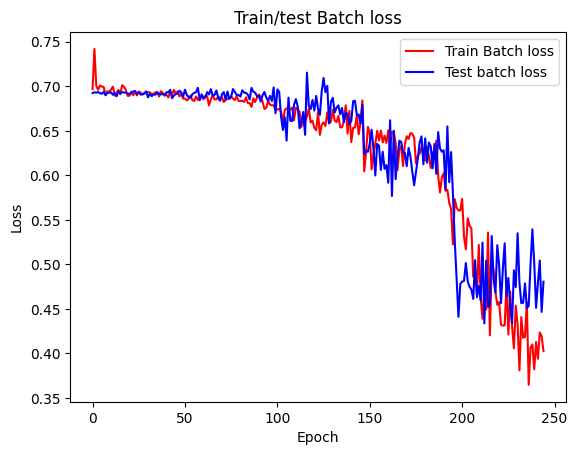

In [119]:
plt.figure()
plt.title('Train/test Batch loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(res_train_batch_loss, c='r', label='Train Batch loss')
plt.plot(res_test_batch_loss, c='b', label='Test batch loss')
plt.legend()

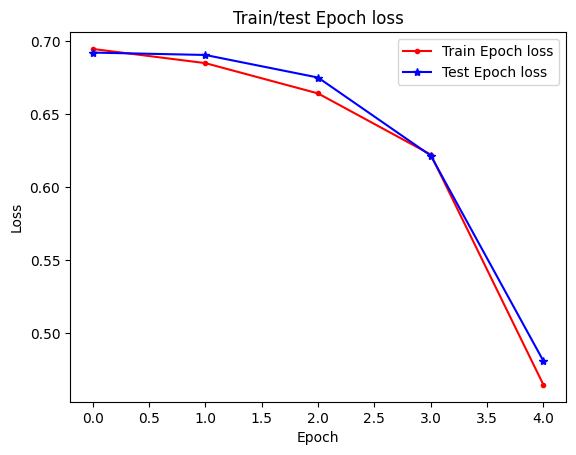

In [116]:
plt.figure()
plt.title('Train/test Epoch loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(res_train_epoch_loss, c='r', marker='.', label='Train Epoch loss')
plt.plot(res_test_epoch_loss, c='b', marker='*', label='Test Epoch loss')
plt.legend()

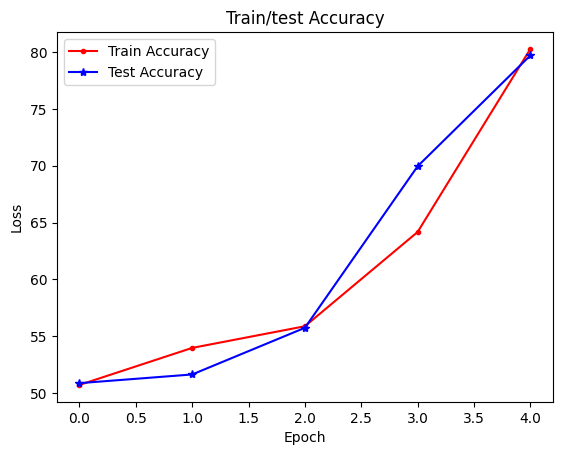

In [126]:
plt.figure()
plt.title('Train/test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(res_train_accuracy, c='r', marker='.', label='Train Accuracy')
plt.plot(res_test_accuracy, c='b', marker='*', label='Test Accuracy')
plt.legend()

In [122]:
res_temp = pd.DataFrame(res_train_metrics).T
res_temp.columns = ['accuracy', 'tp', 'tn', 'fp', 'fn', 'precision_pos', 'precision_neg', 'recall_pos', 'recall_neg', 'f1_pos', 'f1_neg']
res_temp

,accuracy,tp,tn,fp,fn,precision_pos,precision_neg,recall_pos,recall_neg,f1_pos,f1_neg
0,50.72,4805.0,7874.0,4626.0,7695.0,50.95,50.57,38.44,62.99,43.82,56.10
1,53.97,5721.0,7772.0,4728.0,6779.0,54.75,53.41,45.77,62.18,49.86,57.46
2,55.88,5588.0,8381.0,4119.0,6912.0,57.57,54.80,44.70,67.05,50.33,60.31
3,64.17,6786.0,9256.0,3244.0,5714.0,67.66,61.83,54.29,74.05,60.24,67.39
4,80.27,10166.0,9901.0,2599.0,2334.0,79.64,80.92,81.33,79.21,80.48,80.06


In [125]:
res_train_accuracy

[50.71600000000001, 53.971999999999994, 55.876000000000005, 64.168, 80.268]

In [123]:
res_temp = pd.DataFrame(res_test_metrics).T
res_temp.columns = ['accuracy', 'tp', 'tn', 'fp', 'fn', 'precision_pos', 'precision_neg', 'recall_pos', 'recall_neg', 'f1_pos', 'f1_neg']
res_temp

,accuracy,tp,tn,fp,fn,precision_pos,precision_neg,recall_pos,recall_neg,f1_pos,f1_neg
0,50.87,11285.0,1433.0,11067.0,1215.0,50.49,54.12,90.28,11.46,64.76,18.91
1,51.64,11544.0,1365.0,11135.0,956.0,50.90,58.81,92.35,10.92,65.63,18.42
2,55.74,2509.0,11426.0,1074.0,9991.0,70.03,53.35,20.07,91.41,31.20,67.38
3,69.95,6073.0,11414.0,1086.0,6427.0,84.83,63.98,48.58,91.31,61.78,75.24
4,79.70,10568.0,9356.0,3144.0,1932.0,77.07,82.88,84.54,74.85,80.63,78.66


In [124]:
res_test_accuracy

[50.87199999999999, 51.636, 55.74, 69.948, 79.696]

### Checking embeddings manaully

In [ ]:
def calc_cosine_sim(vec1, vec2):
    return (torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))).item()

In [ ]:
# calc_cosine_sim(torch.tensor([1, 0, 0], dtype=torch.float), torch.tensor([1, 0, 0], dtype=torch.float))

In [ ]:
def find_closest_word(word, model, word2idx2, idx2word2):

    weights = model.embedding.weight
    # print(f'weigths.shape: {weights.shape}')

    input_word_idx = word2idx2[word]
    input_word_emb = weights[input_word_idx, :]

    cos_similarity = {}
    for word_index in range(weights.shape[0]):
        if word_index != input_word_idx:
            cos_similarity[word_index] = calc_cosine_sim(input_word_emb, weights[word_index, :])
    # print(f'cosine_similarity: {cos_similarity}')

    sorted_cos_similarity = dict(sorted(cos_similarity.items(),
                                        key=lambda item: item[1],
                                        reverse=True))
    # print(f'sorted_cos_similarity: {sorted_cos_similarity}')

    # Get the top five keys
    top_5_closest_word_index = list(sorted_cos_similarity.keys())[:10]
    # print(f'top_5_closest_word_index: {top_5_closest_word_index}')

    return [idx2word2[idx] for idx in top_5_closest_word_index]

In [ ]:
# Test words
words = ['good', 'movie', 'bad', 'actor', 'action',
         'year', 'immediately', 'husband', 'sister',
         'hand', 'lose', 'director', 'minutes', 'funny',
         'vote', 'brazil', 'finish', 'oldest', 'noise',
         'project', 'poor', 'singer', 'king',
         'queen', 'man', 'woman', 'suck', 'edit']

i = 0
for word in words:
    top_5_closest_word = find_closest_word(word, model, word2idx2, idx2word2)
    print(f'Word: {word} ----- {top_5_closest_word}')

Word: good ----- ['ready', 'andrew', '50s', 'ill', 'linda', 'prefer', 'allen', 'harder', 'cleverly', 'revenge']
Word: movie ----- ['strong', 'creator', 'pervert', 'supply', 'plod', 'pocket', 'someone', 'mainstream', 'raymond', '1983']
Word: bad ----- ['disgust', 'worst', 'filmmakers', 'inconsistent', 'rise', 'betterbr', 'dose', 'start', 'punish', 'parody']
Word: actor ----- ['convince', 'pose', 'safe', 'poetry', 'arm', 'plus', 'giallo', 'femme', '1990', 'edition']
Word: action ----- ['compromise', 'age', 'slightly', 'sharon', 'differences', 'rukh', 'hurt', 'devices', 'patrick', 'beach']
Word: year ----- ['educational', 'eva', 'atrocious', 'robbins', 'la', 'piece', 'nuclear', 'performers', 'victims', 'kansas']
Word: immediately ----- ['manipulate', 'neat', 'christian', 'ban', 'response', 'pervert', 'thief', 'ustinov', 'funniest', 'wasbr']
Word: husband ----- ['nasty', 'bread', 'demon', 'distance', 'safe', 'construction', 'flight', 'beloved', 'wheel', 'profanity']
Word: sister ----- ['ru

# CNN for Sentence classification paper

### Make dataset and dataloader

In [127]:
# Defining custom dataset
class MovieReviewDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    # return number of samples in dataset
    def __len__(self):
        return len(self.reviews)

    # returns sample from dataset at given index idx
    def __getitem__(self, idx):
        return torch.tensor(self.reviews[idx],
                            dtype=torch.long), torch.tensor(self.labels[idx],
                                                            dtype=torch.float)

In [128]:
# Dataset

training_dataset = MovieReviewDataset(train_df['tokenized_enc_pad_review'], train_df['label'])

testing_dataset = MovieReviewDataset(test_df['tokenized_enc_pad_review'], test_df['label'])

In [129]:
# Dataloader

training_dataloader = DataLoader(training_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True)

# shuffle: shuffle data at the start of each epoch
testing_dataloader = DataLoader(testing_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

In [130]:
len(training_dataloader)

49

In [131]:
len(training_dataloader.dataset)

25000

### Model

In [132]:
class CNNClassifier(nn.Module):

    def __init__(self,
                 vocab_size,
                 embed_dim,
                 num_classes,
                 pretrained_embeddings=None,
                 filter_sizes=[3, 4, 5],
                 num_filters=100):

        super(CNNClassifier, self).__init__()

        # If pre-trained embedding present then initialize embedding layer using them and set them to trainable
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        else:
            # If pre-trained embeddings not present
            self.embedding = nn.Embedding(vocab_size, embed_dim)

        # List of conv1D layers
        # Number of conv1D layers: len(filter_sizes) = 3
        # Number of filters in each layer: num_filters (100)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])

        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.embedding(x)  # [batch_size, sentence_length, emb_dim]
        if debug: print(f'x shape (embedding layer): {x.shape}')

        x = x.permute(0, 2, 1)  # [batch_size, emb_dim, sentence_length]
        if debug: print(f'x shape (permute): {x.shape}')

        conv_results = [torch.nn.functional.relu(conv(x)).max(dim=2)[0] for conv in self.convs]
        if debug: print(f'len(conv_results): {len(conv_results)}')

        if debug: print(f'conv1D_0(x) shape: {self.convs[0](x).shape}')
        if debug: print(f'conv1D_1(x) shape: {self.convs[1](x).shape}')
        if debug: print(f'conv1D_2(x) shape: {self.convs[2](x).shape}')

        if debug: print(f'relu(conv1D_0(x)) shape: {torch.nn.functional.relu(self.convs[0](x)).shape}')
        if debug: print(f'relu(conv1D_1(x)) shape: {torch.nn.functional.relu(self.convs[1](x)).shape}')
        if debug: print(f'relu(conv1D_2(x)) shape: {torch.nn.functional.relu(self.convs[2](x)).shape}')

        if debug: print(f'relu(conv1D_0(x)).max(dim=2)[0] shape: {torch.nn.functional.relu(self.convs[0](x)).max(dim=2)[0].shape}')
        if debug: print(f'relu(conv1D_1(x)).max(dim=2)[0] shape: {torch.nn.functional.relu(self.convs[1](x)).max(dim=2)[0].shape}')
        if debug: print(f'relu(conv1D_2(x)).max(dim=2)[0] shape: {torch.nn.functional.relu(self.convs[2](x)).max(dim=2)[0].shape}')

        x = torch.cat(conv_results, dim=1)  # [batch_size, num_filters * len(filter_sizes)]
        if debug: print(f'x shape (cat): {x.shape}')

        x = self.dropout(x)
        if debug: print(f'x shape (dropout): {x.shape}')

        x = self.fc(x)
        if debug: print(f'x shape (fc): {x.shape}')

        return x


In [133]:
vocab_size = vocab_size = len(feature_list) + 2
embedding_dim = 300

model = CNNClassifier(vocab_size=vocab_size,
                      embed_dim=embedding_dim,
                      num_classes=1,
                      pretrained_embeddings=None,
                      filter_sizes=[3, 4, 5],
                      num_filters=100)

### Loss

In [134]:
loss_fn = nn.BCEWithLogitsLoss()

### Optimizer

In [135]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training Loop

In [136]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch):

    # For debugging ON/OFF
    global debug

    global res_train_batch_loss_cnn
    global res_train_epoch_loss_cnn
    global res_train_metrics_cnn
    global res_train_accuracy_cnn

    # Total number of reviews
    size = len(dataloader.dataset)

    # Training epoch loss
    train_loss = 0

    # Number of correct predictions
    num_corr_predictions = 0

    train_data_true_labels = []

    train_data_preds = []

    # For each batch
    for batch, (X, y) in enumerate(dataloader):

         # Turn-OFF debugging after first batch of first epoch
        if batch == 1:
            debug = False

        train_data_true_labels = train_data_true_labels + y.tolist()

        # Model input, true labels shape
        if debug: print(f'Model input shape (current batch): {X.shape}') # [batch_size, num_timesteps]
        if debug: print(f'True labels shape (current shape): {y.shape}') # [batch_size]

        # Model prediction (for current batch)
        pred = model(X)

        # Model loss (for current batch)
        loss = loss_fn(pred.squeeze(), y)

        # Reset the gradients of model parameters
        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Adjust the parameters
        optimizer.step()

        pred_binary = (torch.sigmoid(pred) >= 0.5).float().squeeze()
        num_corr_predictions += (pred_binary == y).sum().item()

        train_data_preds = train_data_preds + pred_binary.tolist()

        # Save train batch loss
        res_train_batch_loss_cnn.append(loss.item())

        # Epoch loss
        train_loss += loss.item()

        # Print summary after every 5 batches
        if (batch+1) % 5 == 0:

            print(f'Last batch processed: {batch+1}')

            # ?? Find: this will be the current batch loss
            loss, current = loss.item(), (batch+1) * len(X)

            print(f"Training batch loss: {loss:.5f} ----- [{current}/{size}]")

            torch.save(model.state_dict(), f'{DRIVE_PATH}{RES_DIR}CNN_Model/model_epoch_{epoch}_batch_{batch+1}.pth')

    res_train_epoch_loss_cnn.append(train_loss/len(dataloader))

    # Training accuracy
    accuracy = (num_corr_predictions / len(dataloader.dataset)) * 100
    # Save training accuracy
    res_train_accuracy_cnn.append(accuracy)

    # Save training metrics
    res_train_metrics_cnn[epoch] = model_evaluate(train_data_true_labels, train_data_preds, False)

### Testing Loop

In [137]:
def test_loop(dataloader, model, loss_fn, epoch):

    global res_test_batch_loss_cnn
    global res_test_epoch_loss_cnn
    global res_test_metrics_cnn
    global res_test_accuracy_cnn

    # Total number of reviews/records in test data
    size = len(dataloader.dataset)

    # Number of batches
    num_batches = len(dataloader)

    # ?? overall loss (total loss for the test set)
    test_loss = 0

    # Number of correct predictions
    num_corr_predictions = 0

    test_data_preds = []
    test_data_true_labels = []

    with torch.no_grad():

        # For each batch
        for X, y in dataloader:
            # print('Length of y: {len(y)}')
            # print(f'Shape of y: {y.shape}')

            test_data_true_labels = test_data_true_labels + y.tolist()

            # Test set prediction (for current batch)
            pred = model(X)
            # print(pred[0:5])

            # Batch loss
            batch_loss = loss_fn(pred.squeeze(), y).item()
            res_test_batch_loss_cnn.append(batch_loss)

            # ?? Batch loss added in overall loss
            test_loss += batch_loss
            # print(f'test_loss: {test_loss}')

            pred_binary = (torch.sigmoid(pred) >= 0.5).float().squeeze()
            # print(f'pred_binary shape: {pred_binary.shape}, length: {len(pred_binary)}')
            # print(type(pred_binary[0]))
            # check_list = (list(pred_binary.numpy()))
            # print(f'{check_list[0:5]}')

            # Savings test set predictions
            test_data_preds = test_data_preds + pred_binary.tolist()

            num_corr_predictions += (pred_binary == y).sum().item()
            # print(f'type(num_corr_predictions): {type(num_corr_predictions)}')
            # print(f'num_corr_predictions: {num_corr_predictions}')

    # print(f'pred: {pred[0:5]}')
    # print(f'pred_binary: {pred_binary[0:5]}')
    # ?? This will be mean batch loss
    test_loss /= num_batches
    res_test_epoch_loss_cnn.append(test_loss)

    # ?? Overall test set accuracy
    # print(f'num_corr_predictions: {num_corr_predictions}')
    # print(f'size: {size}')
    accuracy = (num_corr_predictions / size) * 100
    # print(f'accuracy: {accuracy}')
    res_test_accuracy_cnn.append(accuracy)

    res_test_metrics_cnn[epoch] = model_evaluate(test_data_true_labels, test_data_preds, False)

    print(f"Test set accuracy: {accuracy}%, Mean batch loss: {test_loss} \n")

### Final Training/Testing

In [138]:
debug=True

epochs = 5

# Train set metrics
res_train_batch_loss_cnn = [] # Loss of each batch of each epoch (continuous list)
res_train_epoch_loss_cnn = [] # Epoch loss (mean of all batch losses in this epoch) (single value for each epoch)
res_train_metrics_cnn = {} # Epoch metrics (accuracy, precision, recall F1-score) (at the end of epoch)
res_train_accuracy_cnn = [] # Epoch accuracy

# Test set metrics
res_test_batch_loss_cnn = []
res_test_epoch_loss_cnn = []
res_test_metrics_cnn = {}
res_test_accuracy_cnn = []

for epoch in range(epochs):

    print(f"Epoch: {epoch+1}")

    train_loop(training_dataloader, model, loss_fn, optimizer, epoch)

    test_loop(testing_dataloader, model, loss_fn, epoch)

    print(f"================")

print("Done!")

Epoch: 1
Model input shape (current batch): torch.Size([512, 150])
True labels shape (current shape): torch.Size([512])
x shape (embedding layer): torch.Size([512, 150, 300])
x shape (permute): torch.Size([512, 300, 150])
len(conv_results): 3
conv1D_0(x) shape: torch.Size([512, 100, 148])
conv1D_1(x) shape: torch.Size([512, 100, 147])
conv1D_2(x) shape: torch.Size([512, 100, 146])
relu(conv1D_0(x)) shape: torch.Size([512, 100, 148])
relu(conv1D_1(x)) shape: torch.Size([512, 100, 147])
relu(conv1D_2(x)) shape: torch.Size([512, 100, 146])
relu(conv1D_0(x)).max(dim=2)[0] shape: torch.Size([512, 100])
relu(conv1D_1(x)).max(dim=2)[0] shape: torch.Size([512, 100])
relu(conv1D_2(x)).max(dim=2)[0] shape: torch.Size([512, 100])
x shape (cat): torch.Size([512, 300])
x shape (dropout): torch.Size([512, 300])
x shape (fc): torch.Size([512, 1])
Last batch processed: 5
Training batch loss: 0.78223 ----- [2560/25000]
Last batch processed: 10
Training batch loss: 0.70703 ----- [5120/25000]
Last batch 

### Evaluating results

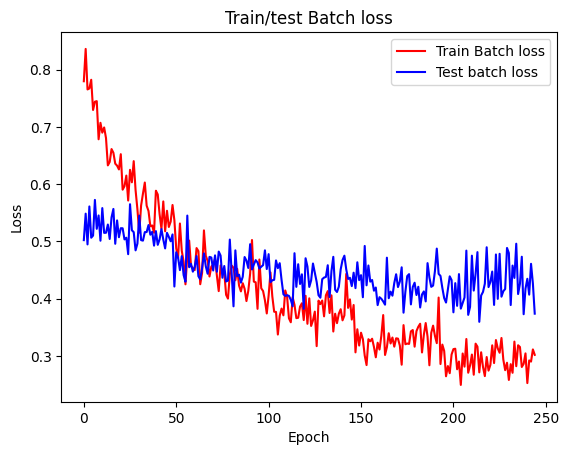

In [146]:
plt.figure()
plt.title('Train/test Batch loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(res_train_batch_loss_cnn, c='r', label='Train Batch loss')
plt.plot(res_test_batch_loss_cnn, c='b', label='Test batch loss')
plt.legend()

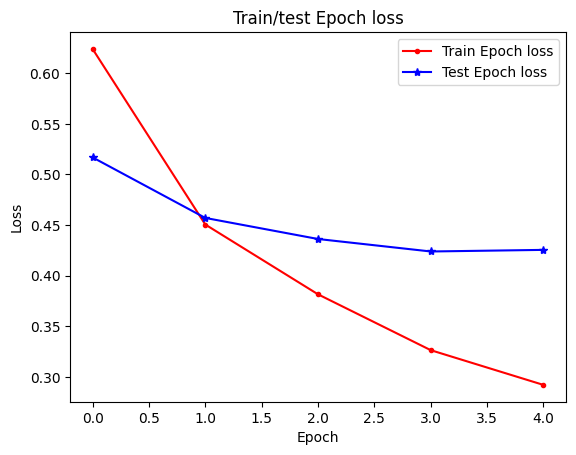

In [147]:
plt.figure()
plt.title('Train/test Epoch loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(res_train_epoch_loss_cnn, c='r', marker='.', label='Train Epoch loss')
plt.plot(res_test_epoch_loss_cnn, c='b', marker='*', label='Test Epoch loss')
plt.legend()

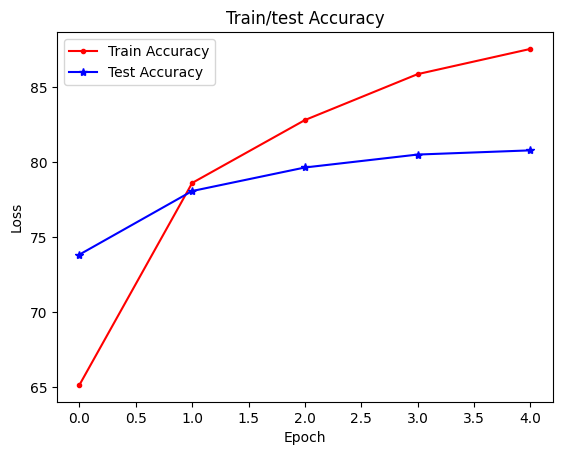

In [148]:
plt.figure()
plt.title('Train/test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(res_train_accuracy_cnn, c='r', marker='.', label='Train Accuracy')
plt.plot(res_test_accuracy_cnn, c='b', marker='*', label='Test Accuracy')
plt.legend()

In [149]:
res_temp = pd.DataFrame(res_train_metrics_cnn).T
res_temp.columns = ['accuracy', 'tp', 'tn', 'fp', 'fn', 'precision_pos', 'precision_neg', 'recall_pos', 'recall_neg', 'f1_pos', 'f1_neg']
res_temp

,accuracy,tp,tn,fp,fn,precision_pos,precision_neg,recall_pos,recall_neg,f1_pos,f1_neg
0,65.13,8230.0,8052.0,4448.0,4270.0,64.92,65.35,65.84,64.42,65.38,64.88
1,78.62,9997.0,9658.0,2842.0,2503.0,77.86,79.42,79.98,77.26,78.91,78.33
2,82.82,10532.0,10173.0,2327.0,1968.0,81.90,83.79,84.26,81.38,83.06,82.57
3,85.89,10853.0,10619.0,1881.0,1647.0,85.23,86.57,86.82,84.95,86.02,85.75
4,87.57,11021.0,10872.0,1628.0,1479.0,87.13,88.03,88.17,86.98,87.65,87.50


In [150]:
res_train_accuracy_cnn

[65.128, 78.62, 82.82000000000001, 85.88799999999999, 87.572]

In [151]:
res_temp = pd.DataFrame(res_test_metrics_cnn).T
res_temp.columns = ['accuracy', 'tp', 'tn', 'fp', 'fn', 'precision_pos', 'precision_neg', 'recall_pos', 'recall_neg', 'f1_pos', 'f1_neg']
res_temp

,accuracy,tp,tn,fp,fn,precision_pos,precision_neg,recall_pos,recall_neg,f1_pos,f1_neg
0,73.84,8881.0,9578.0,2922.0,3619.0,75.24,72.58,71.05,76.62,73.08,74.55
1,78.08,10187.0,9333.0,3167.0,2313.0,76.28,80.14,81.50,74.66,78.80,77.30
2,79.65,10171.0,9742.0,2758.0,2329.0,78.67,80.71,81.37,77.94,80.00,79.30
3,80.52,9620.0,10509.0,1991.0,2880.0,82.85,78.49,76.96,84.07,79.80,81.18
4,80.80,9871.0,10328.0,2172.0,2629.0,81.96,79.71,78.97,82.62,80.44,81.14


In [153]:
res_test_accuracy_cnn

[73.836, 78.08, 79.652, 80.516, 80.796]